
- Assignment Task 1 

Neural Network - discriminative

Naive Bayes classifier - generative

Logistic regression - discriminative

Gaussian mixture model - generative

GANs - generative

LDA - generative

SVM - discriminative

Decision Tree - discriminative

From the definition of generative models we should be able to sample examples from the learned models. This is possible only if we learn the distribution and will be able to sample for features. 

In naive bayes we learn P(X|Y) which lets us sample for X. 

In Gaussian mixture model you learn the guassian distribution parameters i.e mean and variance for each feature and from which the features can be sampled.

GANs - The generator network learns to generate output i.e similar to input by trying to fool the discriminator which discriminated if the image is real or generated. So the generator can generate samples from the input space.

LDA - Learns the dirichlet distribution over all the words for each latent topic. This distrbution is used to sample input data.


- Assignment Task 2 


In [1]:
from nltk.corpus import treebank,brown
import math
import scipy
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.grid_search import RandomizedSearchCV
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, Sized
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed i

In [2]:
corpus = brown.tagged_sents(tagset='universal')

# Last 100 examples are used as test cases
train_data = corpus[:-100] 
test_data = corpus[-10:]

print(len(train_data))
print(len(test_data))

57240
10


In [3]:
#HMM class

class HMM():
    def __init__(self,laplace_constant=0.5):
        self.P = {}
        self.O = {}
        self.S = {}
        self.laplace_constant = 0.5

    def train(self,train_data):
        
        # Assignment Task 2 - Sub Part 1 creating transition, start, emission matrices
        # self.P - transition matix
        # self.O - emission matrix
        # self.S - start matrix
        
        self.tag_dict={}
        self.word_dict={}
        total = 0

        for sent in train_data:
            for elem in sent:
                w = elem[0]
                tag= elem[1]

                if w not in self.word_dict:
                    self.word_dict[w]=0

                if tag not in self.tag_dict:
                    self.tag_dict[tag]=0

                self.word_dict[w]+=1
                self.tag_dict[tag]+=1
   
        for t in self.tag_dict:
            total += self.tag_dict[t]
    
        self.total_tags = total
        for sent in train_data:
            for i in range(len(sent)):
                word = sent[i]
                
                if i == 0:
                    if word[1] not in self.S:
                        self.S[word[1]] = 1
                    else:
                        self.S[word[1]] += 1

                if i == len(sent)-1:
                    if (word[1],word[0]) not in self.O:
                        self.O[(word[1],word[0])] = 1
                    else:
                        self.O[(word[1],word[0])] += 1
                    continue                
                
                word2 = sent[i+1]
                
                if (word[1],word2[1]) not in self.P:
                    self.P[(word[1],word2[1])] = 1
                else:
                    self.P[(word[1],word2[1])] += 1
                
                if (word[1],word[0]) not in self.O:
                    self.O[(word[1],word[0])] = 1
                else:
                    self.O[(word[1],word[0])] += 1
                    
        for (s,s_1) in self.P:
            self.P[(s,s_1)] /= float(self.tag_dict[s])

        for (s,v) in self.O:
            self.O[(s,v)] /= float(self.tag_dict[s])

        start_sum = 0
        for s in self.S:
            start_sum += self.S[s]
        self.start_sum = start_sum
        for s in self.S:
            self.S[s] /= float(start_sum)
            
            
    def transition(self,s1,s2):
        if (s1,s2) not in self.P:
            return self.laplace_constant/(self.laplace_constant*(self.total_tags) + self.queryTag(s1))
            #return 10e-10
        else:
            return self.P[(s1,s2)]
    
    def emission(self,s1,v1):
        if (s1,v1) not in self.O:
            return self.laplace_constant/(self.laplace_constant*(self.total_tags) + self.queryTag(s1))
            #return 10e-10
        else:
            return self.O[(s1,v1)]
        
    def start(self,s):
        if s not in self.S:
            return 1.0/(self.start_sum)
            #return 10e-10
        else:
            return self.S[s]
        
    def getTags(self):
        return self.tag_dict
    
    def getWords(self):
        return self.word_dict
    
    def queryTag(self,s):
        if s not in self.tag_dict:
            return 0
        else:
            return self.tag_dict[s]
        
    def test(self,test_data):
        
        tag_set = self.tag_dict.keys()
        predictions = []
        
        for sent in test_data:
            # Assignment Task 2 - Sub Part 2 Viterbi algorithm
            
            V = {}
            V_1 = {}

            maxi = 0
            decisions = []

            for t in tag_set:
                V[t] = math.log(self.start(t)) + math.log(self.emission(t,sent[0][0]))

            for i in range(1,len(sent)):        
                word = sent[i][0]
                decision = {}
                for t in tag_set:
                    maxi = None
                    for t2 in tag_set:
                        value = math.log(self.emission(t,word)) + V[t2] + math.log(self.transition(t2,t)) 
                        if maxi == None:
                            maxi = value
                            decision[t] = t2
                        if value > maxi:
                            maxi = value
                            decision[t] = t2
                    V_1[t] = maxi

                decisions.append(decision)         
                V = V_1.copy()
                
            maxi = None
            dec = None

            for t in tag_set:
                if maxi == None:
                    maxi = V[t]
                    dec = t
                if V[t] > maxi:
                    maxi = V[t]
                    dec = t

            bestSeq = []
            bestSeq.append(dec)

            for i in range(len(decisions)-1,-1,-1):
                dec = decisions[i][dec]
                bestSeq.append(dec)

            bestSeq.reverse()
            predictions.append(bestSeq)
        return predictions

In [4]:
def sent2labels(sent):
    return [label for i,label in sent]

In [5]:
y_test=[sent2labels(s) for s in test_data]

In [6]:
model = HMM()
model.train(train_data)

In [7]:
# Assignment Task 2 - Sub Part 3

y_predict = model.test(test_data)
#print(type(y_predict))

flat_y_test = [t for s in y_test for t in s]
flat_y_predict = [t for s in y_predict for t in s]
print("Accuracy: ",accuracy_score(flat_y_test,flat_y_predict, normalize=True))


labels = []
for t in model.getTags():
    labels.append(t)

metrics.flat_f1_score(y_test, y_predict, 
                      average='weighted', labels=labels)

Accuracy:  0.9414225941422594


/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9391370192817936

In [8]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_predict, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      0.971     1.000     0.985        33
          X      1.000     0.333     0.500         3
        ADJ      0.938     0.833     0.882        18
        ADP      0.929     0.963     0.945        27
        ADV      0.889     0.889     0.889         9
       VERB      0.941     0.914     0.928        35
        DET      0.971     1.000     0.985        33
       CONJ      1.000     1.000     1.000         7
       NOUN      0.904     0.922     0.913        51
       PRON      1.000     1.000     1.000        12
        PRT      0.917     1.000     0.957        11
        NUM      0.000     0.000     0.000         0

avg / total      0.942     0.941     0.939       239



/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



- Assignment Task 3 


In [11]:
def word2features(sent,i):
    word = sent[i][0]
    
    features ={
    'bias': 1.0, # for stochasticity 
    'first_word': i == 0 ,# Because a sentence can start with only limited words from the corpus
    'last_word' : i == (len(sent)-1) ,# Because a sentence can end with only limited words from the corpus
    'word.lower()': word.lower(), # the actual work 
    'word[-3:]': word[-3:], # last 2 letters for checking verb forms and adjectives
    'word[-2:]': word[-2:], # last 2 letters for checking verb forms and adjectives
    'word.isupper()': word.isupper(), # for checking acronyms
    'word.istitle()': word.istitle(), # for checking propernouns
    'word.isdigit()': word.isdigit(), # for checking numbers
    }
                
    return features

def sent2features(sent):
    return [word2features(sent,i) for i in range(len(sent))]


In [12]:
X_train=[sent2features(s) for s in train_data]
y_train=[sent2labels(s) for s in train_data]

X_test=[sent2features(s) for s in test_data]
y_test=[sent2labels(s) for s in test_data]

In [13]:

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [14]:
y_pred = crf.predict(X_test)
labels=list(crf.classes_)
print(labels)
print(type(labels))
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X']
<class 'list'>


/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9601358414424452

In [15]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000        33
          X      0.000     0.000     0.000         3
        ADJ      1.000     0.833     0.909        18
        ADP      0.963     0.963     0.963        27
        ADV      0.900     1.000     0.947         9
       VERB      0.972     1.000     0.986        35
        DET      1.000     1.000     1.000        33
       CONJ      1.000     1.000     1.000         7
       NOUN      0.927     1.000     0.962        51
       PRON      1.000     0.917     0.957        12
        PRT      0.917     1.000     0.957        11
        NUM      0.000     0.000     0.000         0

avg / total      0.956     0.967     0.960       239



/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
########### BONUS ############
# Hyper-parameters tuning
########## NOTE ############## 
# Set the no of n_jobs to less than the number of cores available in the computer #


crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=48,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=48)]: Done 150 out of 150 | elapsed: 13.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=48,
          param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa9af207e48>, 'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa9af20d048>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(flat_f1_score, average=weighted, labels=['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X']),
          verbose=1)

In [17]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000        33
          X      0.000     0.000     0.000         3
        ADJ      0.933     0.778     0.848        18
        ADP      0.963     0.963     0.963        27
        ADV      0.900     1.000     0.947         9
       VERB      0.921     1.000     0.959        35
        DET      1.000     1.000     1.000        33
       CONJ      1.000     1.000     1.000         7
       NOUN      0.925     0.961     0.942        51
       PRON      1.000     0.917     0.957        12
        PRT      0.917     1.000     0.957        11
        NUM      0.000     0.000     0.000         0

avg / total      0.943     0.954     0.947       239



/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/du0/15CS30008/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.020299136419058658, 'c2': 0.013149205909461906}
best CV score: 0.9651956886266714
model size: 3.32M


Dark blue => 0.9551, dark red => 0.9652


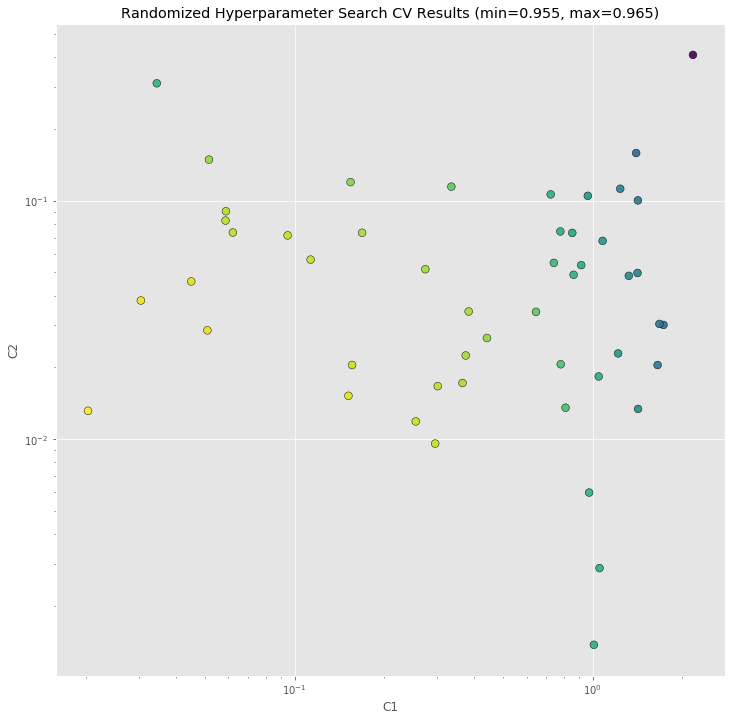

In [19]:
### PLOT Justifying the hyperparameters found

_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))